P-controller:
PD-Controller:


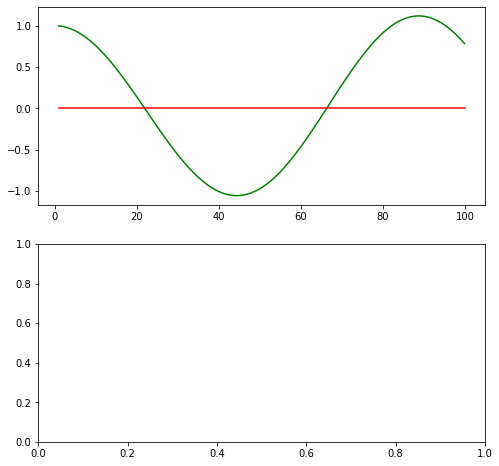

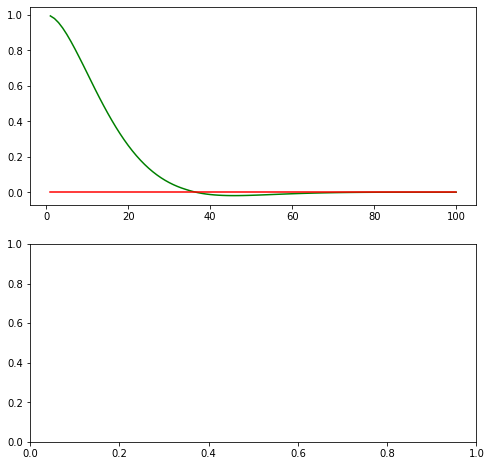

In [35]:
#!/usr/bin/python
# -----------
# User Instructions
#
# Implement a P controller by running 100 iterations
# of robot motion. The desired trajectory for the 
# robot is the x-axis. The steering angle should be set
# by the parameter tau so that:
#
# steering = -tau * crosstrack_error
#
# You'll only need to modify the `run` function at the bottom.
# ------------
 
import random
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------
# 
# this is the Robot class
#

class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)

############## ADD / MODIFY CODE BELOW ####################
# ------------------------------------------------------------------------
#
# run - does a single control run
robot = Robot()
robot.set(0.0, 1.0, 0.0)

def run_p(robot, tau, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    # TODO: your code here
    
    # AE: Do the requested n motion steps
    for i in range(n):
        # AE: In this case cross-track-error equals to y, because we want to keep the robot on the x axis at y = 0.
        cte = robot.y
        angle = -1.0 * tau * cte
        robot.move(angle, 1.0) # AE: move by 1 unit in the updated direction.
        #print(robot)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        
    return x_trajectory, y_trajectory

def run_pd(robot, tau_p, tau_d, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    # TODO: your code here
    
    # AE: We'll need the previous cross-track-error to compare it to current cte, when calculating differential
    # AE: component of angle change.
    cte_prev = robot.y
    
    # AE: Do the requested n motion steps
    for i in range(n):
        # AE: In this case cross-track-error equals to y, because we want to keep the robot on the x axis at y = 0.
        cte = robot.y
        angle = -1.0 * tau_p * cte - tau_d * (cte - cte_prev)
        cte_prev = cte
        robot.move(angle, 1.0) # AE: move by 1 unit in the updated direction.
        #print(robot)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        
    return x_trajectory, y_trajectory

# AE: P-controller output
x_trajectory, y_trajectory = run_p(robot, 0.1, 100)
# n = 13 speed = 2 tau = 0.947451418831 Starting from (0, 1, 0)
#x_trajectory, y_trajectory = run(robot, 0.947451418831, 13, 2.0)

n = len(x_trajectory)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
print("P-controller:")
ax1.plot(x_trajectory, y_trajectory, 'g', label='P controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')

robot = Robot()
robot.set(0.0, 1.0, 0.0)
x_trajectory, y_trajectory = run_pd(robot, 0.2, 3.0)
n = len(x_trajectory)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
print("PD-Controller:")
ax1.plot(x_trajectory, y_trajectory, 'g', label='PD controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
